### 基于LightGBM的LambdaMART排序模型
基本思想：为每个预测时间步都训练一个模型，输入为前段时间的信息，输出为预测时间步的排序信息

训练集和测试集应以时间段来划分

In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from utils import *
import lightgbm as lgb

random.seed(42)
np.random.seed(42)

读取数据

In [2]:
# (term_num, time_steps, feature_num)

gene_arr_path = r'../output/gene_editing/result.array'
transplant_arr_path = r'../output/transplant/old_school.array'

gene_name_path = r'../output/gene_editing/ordered_list.list'
transplant_name_path = r'../output/transplant/ordered_list.list'

gene_arr = pickle.load(open(gene_arr_path, mode='rb'))
transplant_arr = pickle.load(open(transplant_arr_path, mode='rb'))

gene_name = pickle.load(open(gene_name_path, mode='rb'))
transplant_name = pickle.load(open(transplant_name_path, mode='rb'))

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

print('Length of the gene_name list:', len(gene_name))
print('Length of the transplant_name list:', len(transplant_name))

Shape of the gene_editing array: (2643, 17, 11)
Shape of the transplant array: (5141, 17, 11)
Length of the gene_name list: 2643
Length of the transplant_name list: 5141


### 截断数据
2019年的数据是收集有误，抛弃2019

In [4]:
gene_arr = gene_arr[:, :-1, :]
transplant_arr = transplant_arr[:, :-1, :]

print('Shape of the gene_editing array:',gene_arr.shape)
print('Shape of the transplant array:',transplant_arr.shape)

Shape of the gene_editing array: (2643, 16, 11)
Shape of the transplant array: (5141, 16, 11)


### 规范数据并获取训练集和测试集

In [7]:
scaler, data = scale_data(transplant_arr, 'standard')

def split_data_by_time(data, scaler):
    # 输入14年的数据，预测1年的
    X_train, y_train, y_train_es = data[:, :14, :], transplant_arr[:, 14, -1].astype(int), transplant_arr[:, 14, -2]
    X_test, y_test, y_test_es = data[:, 1:15, :], transplant_arr[:, 15, -1].astype(int), transplant_arr[:, 15, -2]
    return X_train, X_test, y_train, y_test, y_train_es, y_test_es

In [8]:
X_train, X_test, y_train, y_test, y_train_es, y_test_es = split_data_by_time(data, scaler)
X_train = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(-1, X_test.shape[1] * X_test.shape[2])

In [278]:
# 这个方法不行，label最大31
# ordered_train = sorted(range(len(y_train_es)), key=lambda k:y_train_es[k], reverse=True)
# ordered_test = sorted(range(len(y_test_es)), key=lambda k:y_test_es[k], reverse=True)

# for i in range(len(ordered_train)):
#     y_train[ordered_train[i]] = len(ordered_train) - i - 1
#     y_test[ordered_test[i]] = len(ordered_test) - i - 1

### 因为Ranker只接受整数值，所以更具体的相关性没法区分，需要分组对比构造训练集和测试集
效果非常差

In [131]:
# def rank_sampling(X, y, es):
#     result_X = []
#     result_y = []
    
#     _X = X.copy()
#     _y = y.copy()
#     _es = es.copy()
#     score_lookup = list(zip(_X, _y, _es))
    
#     sample_lookup = {}
    
#     for features, label, escore in score_lookup:
#         if label in sample_lookup:
#             sample_lookup[label].append((features, escore))
#         else:
#             sample_lookup[label] = [(features, escore)]
#     i = 0
#     while i < len(score_lookup):
#         candidates = [(score_lookup[i][0], score_lookup[i][2])]
        
#         for label in range(5):
#             idx = np.random.choice(len(sample_lookup[label]), 2)
#             for j in idx:
#                 candidates.append(sample_lookup[label][j])
        
#         candidates = sorted(candidates, key=lambda x: x[1], reverse=True)
#         for k in range(len(candidates)):
#             result_X.append(candidates[k][0])
#             result_y.append(len(candidates) - k)
#         i += 1
#     return np.array(result_X), np.array(result_y)

def pair_wise_data(X, y, es):
    pass

In [133]:
X_train, y_train = rank_sampling(X_train, y_train, y_train_es)
X_test, y_test = rank_sampling(X_test, y_test, y_test_es)

In [136]:
X_test.shape

(56551, 154)

In [9]:
# q_train = [11] * len(transplant_arr)
# q_test = [11] * len(transplant_arr)
q_train = [X_train.shape[0]]
q_test = [X_test.shape[0]]

In [10]:
gbm = lgb.LGBMRanker(class_weight='balanced')
gbm.fit(X_train, y_train, group=q_train, eval_set=[(X_test, y_test)],
eval_group=[q_test], eval_at=[10, 20], early_stopping_rounds=400, verbose=True,
callbacks=[lgb.reset_parameter(learning_rate=lambda x: 0.95 ** x * 0.1)])

[1]	valid_0's ndcg@10: 0.606847	valid_0's ndcg@20: 0.578562
Training until validation scores don't improve for 400 rounds
[2]	valid_0's ndcg@10: 0.77878	valid_0's ndcg@20: 0.747584
[3]	valid_0's ndcg@10: 0.856824	valid_0's ndcg@20: 0.787084
[4]	valid_0's ndcg@10: 0.856824	valid_0's ndcg@20: 0.787084
[5]	valid_0's ndcg@10: 0.856824	valid_0's ndcg@20: 0.787084
[6]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.778082
[7]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.796239
[8]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.796239
[9]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.796239
[10]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.796239
[11]	valid_0's ndcg@10: 0.794641	valid_0's ndcg@20: 0.796239
[12]	valid_0's ndcg@10: 0.704617	valid_0's ndcg@20: 0.771651
[13]	valid_0's ndcg@10: 0.704617	valid_0's ndcg@20: 0.771651
[14]	valid_0's ndcg@10: 0.704617	valid_0's ndcg@20: 0.771651
[15]	valid_0's ndcg@10: 0.704617	valid_0's ndcg@20: 0.771651
[16]	valid_0's ndcg@10: 0.704617	

LGBMRanker(boosting_type='gbdt', class_weight='balanced', colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
           random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
y_pred = gbm.predict(X_test)

In [12]:
sorted(range(len(y_pred)), key=lambda k:y_pred[k], reverse=True)

[3732,
 4641,
 4559,
 89,
 2381,
 3446,
 1450,
 110,
 326,
 617,
 753,
 1089,
 1212,
 2355,
 2924,
 3727,
 4182,
 4956,
 2763,
 2628,
 618,
 1349,
 9,
 2522,
 804,
 1479,
 3477,
 958,
 504,
 692,
 1490,
 538,
 2915,
 1705,
 241,
 2657,
 27,
 1003,
 1630,
 1875,
 219,
 2022,
 897,
 427,
 542,
 543,
 3247,
 185,
 422,
 1330,
 2101,
 4261,
 4166,
 705,
 485,
 2638,
 933,
 807,
 1205,
 3706,
 1438,
 58,
 3330,
 1007,
 1008,
 3347,
 566,
 84,
 1547,
 515,
 2310,
 367,
 769,
 1393,
 1643,
 3640,
 4380,
 1560,
 400,
 741,
 805,
 1919,
 1708,
 125,
 2640,
 2172,
 260,
 3944,
 1083,
 200,
 3158,
 4460,
 1397,
 689,
 1545,
 4920,
 406,
 1151,
 2053,
 1382,
 626,
 610,
 4566,
 265,
 4298,
 4107,
 2547,
 939,
 3374,
 451,
 269,
 1571,
 2556,
 1753,
 150,
 24,
 2741,
 211,
 183,
 4878,
 4879,
 4880,
 2944,
 3866,
 2698,
 4148,
 3575,
 2489,
 687,
 3770,
 1133,
 3231,
 484,
 1694,
 327,
 1140,
 904,
 682,
 2729,
 221,
 2291,
 1253,
 16,
 1884,
 304,
 469,
 844,
 29,
 37,
 686,
 1916,
 2379,
 2754,
 

In [13]:
sorted(range(len(y_test)), key=lambda k:y_test[k], reverse=True)

[0,
 9,
 10,
 16,
 37,
 39,
 53,
 84,
 89,
 99,
 102,
 103,
 110,
 117,
 125,
 150,
 152,
 157,
 169,
 182,
 185,
 193,
 194,
 200,
 207,
 217,
 219,
 247,
 260,
 264,
 265,
 295,
 305,
 312,
 317,
 326,
 359,
 367,
 376,
 382,
 400,
 417,
 422,
 427,
 428,
 437,
 443,
 445,
 451,
 461,
 469,
 470,
 473,
 484,
 493,
 503,
 512,
 515,
 525,
 533,
 534,
 538,
 540,
 542,
 543,
 545,
 558,
 559,
 566,
 610,
 613,
 615,
 617,
 622,
 629,
 654,
 657,
 668,
 682,
 684,
 686,
 692,
 747,
 758,
 769,
 776,
 778,
 801,
 804,
 807,
 812,
 841,
 844,
 845,
 897,
 905,
 933,
 948,
 952,
 958,
 970,
 973,
 1003,
 1007,
 1008,
 1012,
 1049,
 1073,
 1089,
 1109,
 1136,
 1151,
 1157,
 1159,
 1183,
 1212,
 1219,
 1253,
 1261,
 1276,
 1330,
 1350,
 1359,
 1365,
 1382,
 1397,
 1414,
 1438,
 1447,
 1450,
 1468,
 1479,
 1490,
 1502,
 1533,
 1545,
 1552,
 1553,
 1560,
 1608,
 1622,
 1643,
 1664,
 1680,
 1694,
 1705,
 1708,
 1718,
 1721,
 1733,
 1805,
 1810,
 1824,
 1875,
 1891,
 1897,
 1917,
 1919,
 1932,
 

In [14]:
y_true = sorted(range(len(transplant_arr)), key=lambda k:transplant_arr[k, -1, -2], reverse=True)
y_true

[1545,
 150,
 3587,
 1447,
 200,
 1479,
 3028,
 933,
 193,
 973,
 4460,
 1212,
 265,
 2957,
 3348,
 4225,
 2628,
 812,
 1680,
 2875,
 2258,
 4199,
 4453,
 2559,
 3727,
 185,
 400,
 1382,
 367,
 312,
 2915,
 4182,
 247,
 305,
 776,
 1810,
 4148,
 804,
 1708,
 897,
 382,
 668,
 758,
 801,
 1365,
 1622,
 2005,
 2160,
 3063,
 3064,
 4322,
 2167,
 4109,
 1643,
 769,
 2401,
 1012,
 1414,
 1468,
 2008,
 2418,
 512,
 538,
 2101,
 2924,
 958,
 1450,
 3062,
 2556,
 2310,
 422,
 469,
 844,
 515,
 102,
 1350,
 1502,
 2944,
 4380,
 610,
 0,
 103,
 1917,
 4415,
 4529,
 4530,
 682,
 326,
 1919,
 9,
 427,
 2244,
 2381,
 117,
 4399,
 219,
 2355,
 417,
 125,
 2436,
 807,
 182,
 3446,
 4261,
 470,
 37,
 152,
 376,
 654,
 3035,
 4800,
 110,
 3640,
 3944,
 1089,
 39,
 99,
 169,
 443,
 484,
 503,
 684,
 905,
 1721,
 1824,
 2440,
 2527,
 3065,
 3692,
 3837,
 4335,
 4440,
 4447,
 4606,
 4731,
 5050,
 1875,
 4235,
 1007,
 1008,
 207,
 445,
 4454,
 1159,
 1003,
 4641,
 295,
 1136,
 3993,
 1109,
 2593,
 3562,
 1

In [17]:
y_test[89]

4

In [55]:
y_pred[2638]

2.611440213082302

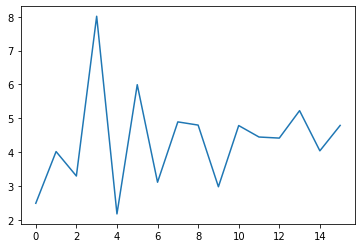

In [18]:
plt.plot(transplant_arr[958, :, -2])

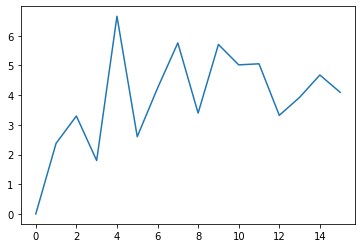

In [285]:
plt.plot(transplant_arr[110, :, -2])

In [155]:
transplant_name[2638]

(2638, 'remote ischemic conditioning')

In [218]:
eval_model('ndcg', np.expand_dims(y_test,axis=1), np.expand_dims(y_pred, axis=1), None)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


(0.8213689751359761, [0.8213689751359761])

In [303]:
yt, yp = eval_model2('classification', np.expand_dims(y_test, axis=1), np.expand_dims(y_pred, axis=1), None)

[[2.]
 [3.]
 [4.]]
[[0.16190206]
 [0.3041031 ]
 [0.43625465]]
259


In [305]:
from sklearn.metrics import classification_report

In [306]:
print(classification_report(yt, yp))

              precision    recall  f1-score   support

           1       0.77      0.78      0.77      3551
           2       0.17      0.20      0.18       663
           3       0.27      0.21      0.24       664
           4       0.29      0.29      0.29       263

    accuracy                           0.60      5141
   macro avg       0.37      0.37      0.37      5141
weighted avg       0.60      0.60      0.60      5141

